<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/LogisticRegression_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**


In [96]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [97]:
%pip install torchmetrics --quiet

In [98]:
import torchmetrics
import torchvision

In [99]:
from torch import nn

In [100]:
from functorch import jvp
from functools import partial
import time 

In [101]:
import matplotlib.pyplot as plt

# **Loading and preprocessing the data**

In [102]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

In [103]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [104]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [105]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [106]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

# **Define Logistic Regression**

In [107]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self, input_size, w, b):
    super().__init__()
    self.weight = nn.Parameter(w)
    self.bias = nn.Parameter(b)

  def forward(self, x):
    x = x.reshape(1, -1)
    return torch.softmax(x@self.weight + self.bias, 1)

In [108]:
# We check if CUDA is available. 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Initialize the parameters**

In [109]:
# We initialize the parameters randomly and the model with an input size
w = torch.randn((4, 3), requires_grad=False)
b = torch.randn((3, ), requires_grad=False)
LG = SimpleLogisticRegression(4, w, b)

In [110]:
# We try our model with the first example
print(LG(Xtrain[0]))

tensor([[0.6197, 0.3468, 0.0335]], grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [116]:
def pred(x,w,b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return ypred

In [117]:
ypred=pred(Xtrain,w,b)

# **Define accuracy**

In [118]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [119]:
# Average accuracy at initialization is 33% (random guessing).
accuracy(ytrain, ypred)

tensor(0.4360)

# **Define Cross Entropy**

We have defined one cross entropy function for each parameter because we will define later partial functions and the parameters need to be in different order







In [120]:
def cross_entropyW(w, ytrue, x, b):
  ypred=pred(x,w,b)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [121]:
def cross_entropyB(b, ytrue, x, w):
  ypred=pred(x,w,b)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [122]:
def cross_entropy(ytrue,ypred):
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [123]:
# We check that the output of all the cross extropy functions is the same
print(cross_entropyB(b, ytrain,Xtrain, w))
print(cross_entropyW(w,ytrain,Xtrain,b))
print(cross_entropy(ytrain,ypred))

tensor(2.5076)
tensor(2.5076)
tensor(2.5076)


## **Other optimization functions**

In [124]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [125]:
def rosenbrock_function(x):
  sum=0
  for i in range (x.size(0) -1):
    sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(1-x[i], 2))
  return sum

In [126]:
def sphere_function(x):
  sum=0
  for i in range(x.size(0)):
    sum += torch.pow(x[i], 2)
  return sum

# **Train and evaluate the network**


In [127]:
def train_fwd_gradient(x, y):

  losses = [] # Vector with the cross entropy values of test set
  accuracies = [] # Vector with the accuracy values of test set
  errors=[] # Vector with the number of misclassification of the test set

  l_rate0 = 0.2 # Learning rate used 

  # Initialize the parameters
  w = torch.randn((4, 3),requires_grad=False)
  b = torch.randn((3, ),requires_grad=False)

  loss = cross_entropyW(w, y, x, b) # Loss function

  # Calculate the start time 
  t=0
  t0=time.time()
  print('Time', t, 'loss', loss)

  while (loss>0.3) :

    # vw and wb are defined as a perturbation vector taken as a multivariate random variable,such that their scalar components vi are independent for all i, and have zero mean and unit variance .

    vw=torch.randn(w.shape)
    vw = (vw - torch.mean(vw))/torch.std(vw)
    vb=torch.randn(b.shape)
    vb = (vb - torch.mean(vb))/torch.std(vb)

    # We define a partial function for each of the parameter
    fw = partial(cross_entropyW,ytrue=y, x=x, b=b)
    fb = partial(cross_entropyB,ytrue=y, x=x, w=w)

    # We compute the cross entropy and the directional derivative of cross entropy at each parameters in direction v, simultaneously and without having to compute ∇cross_entropy in the process
    # This is also know as formard-mode autodiff
    ftw, dtw = jvp(fw,(w, ), (vw, ))
    ftb, dtb = jvp(fb,(b, ), (vb, ))

    # We multiply the scalar directional derivative ∇cross_entropy(θ)·v with vector v and obtain g(θ), the forward gradient (where θ represents each one of out parameters)
    gtw = vw*dtw
    gtb = vb*dtb

    # Update the parameters
    w = w - l_rate0*gtw
    b = b - l_rate0*gtb

    # We calculate the number of misclassification of the test set with the updated model and we add to the errors vector
    LG = SimpleLogisticRegression(4, w, b)
    ypredT=torch.randn(Xtest.size(0),3)
    error=0
    for i in range (Xtest.size(0)):
      ypredT[i]=LG(Xtest[i])
      if (LG(Xtest[i]).argmax(1)- ytest[i])!=0:
        error = error+ 1
    
    errors.append(error)

    # We calculate the accuracy of the test set with the updated model and we add to the accuracy vector
    accuracies.append(accuracy(ytest,ypredT).item())

    # We calculate the cross_entropy of the test set with the updated model and we add to the accuracy vector
    loss=cross_entropyW(w, y, x, b)
    lossT = cross_entropy(ytest,ypredT)
    losses.append(lossT.detach().item())

    #We add the execution time of the iteration 
    t1=time.time()
    t+=t1-t0
    t0=t1

    print('Time', t, 'loss', loss)

  return w, b,errors,accuracies,losses

In [128]:
w, b,errors,accuracies,losses = train_fwd_gradient(Xtrain, ytrain)

Time 0 loss tensor(1.4102)
Time 0.11979818344116211 loss tensor(1.3993)
Time 0.21145033836364746 loss tensor(1.3477)
Time 0.30492734909057617 loss tensor(1.2936)
Time 0.4009993076324463 loss tensor(1.2647)
Time 0.49408769607543945 loss tensor(1.2578)
Time 0.587735652923584 loss tensor(1.2512)
Time 0.6851868629455566 loss tensor(1.2445)
Time 0.7818267345428467 loss tensor(1.2111)
Time 0.8758301734924316 loss tensor(1.1924)
Time 0.9825179576873779 loss tensor(1.1804)
Time 1.0769846439361572 loss tensor(1.1725)
Time 1.1663267612457275 loss tensor(1.1665)
Time 1.2672839164733887 loss tensor(1.1633)
Time 1.3578853607177734 loss tensor(1.1594)
Time 1.4482569694519043 loss tensor(1.1486)
Time 1.5488464832305908 loss tensor(1.1449)
Time 1.643822431564331 loss tensor(1.1328)
Time 1.735442876815796 loss tensor(1.1204)
Time 1.8345718383789062 loss tensor(1.1190)
Time 1.9347445964813232 loss tensor(1.1073)
Time 2.0271050930023193 loss tensor(1.1047)
Time 2.1205408573150635 loss tensor(1.0970)
Time

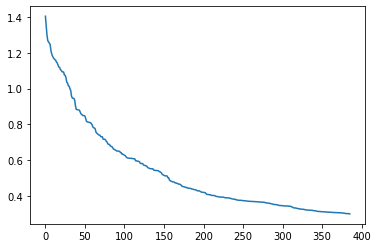

In [129]:
plt.plot(losses)

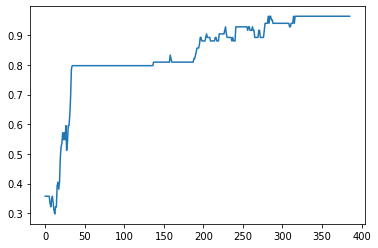

In [130]:
plt.plot(accuracies)

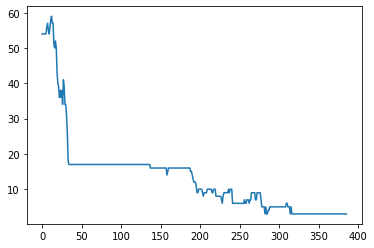

In [131]:
plt.plot(errors)